# Simulation study

In [1]:
# import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import roc_auc_score
from scipy.sparse.linalg import svds
import sklearn.metrics as metrics
#import functions from files
import lanl_function as lanl
import zhu
import gibbs_function as gib
np.random.seed(123)

# Simulation of random networks from stochastic block model

In [ ]:
from collections import Counter
from scipy.sparse import coo_matrix
import random

def random_sim_A(M, N, T, d, add_dynamics=False):
    A = {}
    A_count = {}

    B = np.random.beta(a=1,b=5, size=d*d).reshape((d, d))

    Z = np.array([random.randint(0,d-1) for m in range(M)])
    Z_star = np.array([random.randint(0,d-1) for n in range(N)])

    if add_dynamics:
        #theta = np.random.beta(a=1, b=1, size=M)
        #theta_star = np.random.beta(a=2, b=2, size=N)
        theta = np.ones((M))*0.5
        theta_star = np.ones((N))*0.5


    for t in range(T+1):
        A0 = Counter()
        if add_dynamics:
            Q = np.random.binomial(n=1, p=theta)
            Q_star = np.random.binomial(n=1, p=theta_star)
        else:
            Q = np.ones((M,))
            Q_star = np.ones(N,)

        for i in range(M):
            for j in range(N):
                link_ij = np.random.binomial(n=1, p=B[int(Z[i]), int(Z_star[j])])*Q[i]*Q_star[j]
                if link_ij==1:
                    A0[i,j] = 1

        A[t] = lanl.counter2A(A0,m=M,n=N)
        A_count[t] = A0
    
    return A, A_count

### Plot of cluster

In [ ]:
M = 50
N = 100
d = 2 #easy for visualisation
T = 5

A = {}
A_count = {}

B = np.random.beta(a=1,b=5, size=d*d).reshape((d, d))

Z = np.array([random.randint(0,d-1) for m in range(M)])
Z_star = np.array([random.randint(0,d-1) for n in range(N)])

theta = np.ones((M))*1
theta_star = np.ones((N))*1


for t in range(T+1):
        A0 = Counter()
        Q = np.random.binomial(n=1, p=theta)
        Q_star = np.random.binomial(n=1, p=theta_star)


        for i in range(M):
            for j in range(N):
                link_ij = np.random.binomial(n=1, p=B[int(Z[i]), int(Z_star[j])])*Q[i]*Q_star[j]
                if link_ij==1:
                    A0[i,j] = 1

        A[t] = lanl.counter2A(A0,m=M,n=N)
        A_count[t] = A0

A_dense = gib.convert_to_dense(A)

In [ ]:
# initialisation
x0, y0 = gib.init_xy(A, T, d)
Q0, Q0_star = gib.init_Q(A, T, M, N)

N0_mat, I0, I0_star = gib.sim_N_I(x0, y0, M, N, T, d, A_dense)

I1 = 1.0* I0
I1_star = 1.0*I0_star

A0_sum_tj, A0_sum_ti = gib.sum_A(A, T, M, N)

# parameters of priors
a_x = 1
b_x = 2
c_x = 0.1

a_y = 1
b_y = 0.5
c_y = 0.3

alpha_x = 0.1
beta_x = 0.1
alpha_y = 0.3
beta_y = 1

# gibbs sampler
zeta_set = {}
zeta_star_set = {}
x_set = {}
y_set = {}
theta_set = {}
theta_star_set = {}
Q_set = {}
Q_star_set = {}
N_mat_set = {}

x_set[0] = x0
y_set[0] = y0
Q_set[0] = Q0
Q_star_set[0] = Q0_star

num_iteration = 200

for num in range(1, num_iteration+1):
    zeta_set[num] = gib.sim_zeta( a_x, b_x, c_x, x_set[num-1], M, d)
    zeta_star_set[num] = gib.sim_zeta( a_y, b_y, c_y, y_set[num-1], N, d)

    x_set[num] = gib.sim_xy(y_set[num-1], I0_star, zeta_set[num], Q_set[num-1], Q_star_set[num-1], a_x, M, d)
    y_set[num] = gib.sim_xy(x_set[num], I0, zeta_star_set[num], Q_star_set[num-1], Q_set[num-1], a_y, N, d)

    theta_set[num] = gib.sim_theta(alpha_x, beta_x, Q_set[num-1], T, M)
    theta_star_set[num] = gib.sim_theta(alpha_y, beta_y, Q_star_set[num-1], T, N)

    Q_set[num] = gib.sim_Q(A0_sum_tj, x_set[num], y_set[num], Q_star_set[num-1], theta_set[num], M, T)
    Q_star_set[num] = gib.sim_Q(A0_sum_ti, y_set[num], x_set[num], Q_set[num], theta_star_set[num], N, T)
    

    N_mat_set[num],I0, I0_star = gib.sim_N_I(x_set[num], y_set[num], M, N, T, d, A_dense)

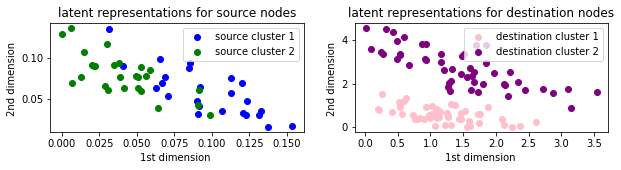

In [ ]:
latent_x = x_set[num]
latent_y = y_set[num]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,2))

ax1.scatter(latent_x[Z==0,0], latent_x[Z==0,1],color="blue", label="source cluster 1")
ax1.scatter(latent_x[Z==1,0], latent_x[Z==1,1],color="green", label="source cluster 2")
ax1.legend()
ax1.set_xlabel("1st dimension ")
ax1.set_ylabel("2nd dimension ")
ax1.set_title("latent representations for source nodes")

ax2.scatter(latent_y[Z_star==0,0], latent_y[Z_star==0,1],color="pink", label="destination cluster 1")
ax2.scatter(latent_y[Z_star==1,0], latent_y[Z_star==1,1],color="purple", label="destination cluster 2")
ax2.legend()
ax2.set_xlabel("1st dimension ")
ax2.set_ylabel("2nd dimension ")
ax2.set_title("latent representations for destination nodes")

plt.show()

## harm of all-zero columns/rows in obtaining latent features

In [ ]:
M = 50
N = 100
d = 2 #easy for visualisation
T = 5

A = np.load('my_matrixA.npy',allow_pickle=True).any()
A_count = np.load('my_countA.npy',allow_pickle=True).any()
#A, A_count = random_sim_A(M, N, T, d, add_dynamics=True)
A_dense = gib.convert_to_dense(A)

### Run MCMC to obtain latent features with and without node dyamics

In [ ]:
# initialisation
x0, y0 = gib.init_xy(A, T, d)
Q0, Q0_star = gib.init_Q(A, T, M, N)

N0_mat, I0, I0_star = gib.sim_N_I(x0, y0, M, N, T, d, A_dense)

I1 = 1.0* I0
I1_star = 1.0*I0_star

A0_sum_tj, A0_sum_ti = gib.sum_A(A, T, M, N)

# parameters of priors
a_x = 1
b_x = 2
c_x = 0.1

a_y = 1
b_y = 0.5
c_y = 0.3

alpha_x = 0.1
beta_x = 0.1
alpha_y = 0.3
beta_y = 1


# gibbs sampler
zeta_set = {}
zeta_star_set = {}
x_set = {}
y_set = {}
theta_set = {}
theta_star_set = {}
Q_set = {}
Q_star_set = {}
N_mat_set = {}

x_set[0] = x0
y_set[0] = y0
Q_set[0] = Q0
Q_star_set[0] = Q0_star

num_iteration = 500


for num in range(1, num_iteration+1):
    zeta_set[num] = gib.sim_zeta( a_x, b_x, c_x, x_set[num-1], M, d)
    zeta_star_set[num] = gib.sim_zeta( a_y, b_y, c_y, y_set[num-1], N, d)

    x_set[num] = gib.sim_xy(y_set[num-1], I0_star, zeta_set[num], Q_set[num-1], Q_star_set[num-1], a_x, M, d)
    y_set[num] = gib.sim_xy(x_set[num], I0, zeta_star_set[num], Q_star_set[num-1], Q_set[num-1], a_y, N, d)

    theta_set[num] = gib.sim_theta(alpha_x, beta_x, Q_set[num-1], T, M)
    theta_star_set[num] = gib.sim_theta(alpha_y, beta_y, Q_star_set[num-1], T, N)

    Q_set[num] = gib.sim_Q(A0_sum_tj, x_set[num], y_set[num], Q_star_set[num-1], theta_set[num], M, T)
    Q_star_set[num] = gib.sim_Q(A0_sum_ti, y_set[num], x_set[num], Q_set[num], theta_star_set[num], N, T)
    

    N_mat_set[num],I0, I0_star = gib.sim_N_I(x_set[num], y_set[num], M, N, T, d, A_dense)

# gibbs sampler
zeta_set2 = {}
zeta_star_set2 = {}
x_set2 = {}
y_set2 = {}
N_mat_set2 = {}

x_set2[0] = x0
y_set2[0] = y0

num_iteration = 500

Q1 = np.ones((M, T))
Q1_star = np.ones((N, T))

for num in range(1, num_iteration+1):
    zeta_set2[num] = gib.sim_zeta( a_x, b_x, c_x, x_set2[num-1], M, d)
    zeta_star_set2[num] = gib.sim_zeta( a_y, b_y, c_y, y_set2[num-1], N, d)

    x_set2[num] = gib.sim_xy(y_set2[num-1], I1_star, zeta_set2[num], Q1, Q1_star, a_x, M, d)
    y_set2[num] = gib.sim_xy(x_set2[num], I1, zeta_star_set2[num], Q1_star, Q1, a_y, N, d)

    N_mat_set2[num],I1, I1_star = gib.sim_N_I(x_set2[num], y_set2[num], M, N, T, d, A_dense)


In [ ]:
## compare latent features of all-zero source node
# all-zero count source node
zero_count_x_idx = np.where(np.sum(A0_sum_tj,axis=1)==0)
print(zero_count_x_idx)
# all-zero count destination node
zero_count_y_idx = np.where(np.sum(A0_sum_ti,axis=1)==0)
print(zero_count_y_idx)

select_idx = num-1
latent_x = x_set[select_idx]
latent_x2 = x_set2[select_idx]
latent_y = y_set[select_idx]
latent_y2 = y_set2[select_idx]


fig, ax = plt.subplots(2,2,figsize=(10,4))
ax1, ax2, ax3, ax4 = ax[0,0], ax[0,1], ax[1,0], ax[1,1]

ax1.scatter(latent_x[:,0], latent_x[:,1])
ax1.scatter(latent_x[zero_count_x_idx[0],0], latent_x[zero_count_x_idx[0],1],color="red")
ax1.scatter(latent_x[zero_count_x_idx[1],0], latent_x[zero_count_x_idx[1],1],color="orange")
ax1.set_xlabel("1st dimension ")
ax1.set_ylabel("2nd dimension ")

ax2.scatter(latent_x2[:,0], latent_x2[:,1])
ax2.scatter(latent_x2[zero_count_x_idx[0],0], latent_x2[zero_count_x_idx[0],1],color="red")
ax2.scatter(latent_x2[zero_count_x_idx[1],0], latent_x2[zero_count_x_idx[1],1],color="orange")
ax2.set_xlabel("1st dimension ")
ax2.set_ylabel("2nd dimension ")

ax3.scatter(latent_y[:,0], latent_y[:,1])
ax3.scatter(latent_y[zero_count_y_idx[0],0], latent_y[zero_count_y_idx[0],1], color="red")
ax3.scatter(latent_y[zero_count_y_idx[1],0], latent_y[zero_count_y_idx[1],1], color="orange")
ax3.scatter(latent_y[zero_count_y_idx[2],0], latent_y[zero_count_y_idx[2],1], color="pink")
ax3.set_xlabel("1st dimension ")
ax3.set_ylabel("2nd dimension ")

ax4.scatter(latent_y2[:,0], latent_y2[:,1])
ax4.scatter(latent_y2[zero_count_y_idx[0],0], latent_y2[zero_count_y_idx[0],1], color="red")
ax4.scatter(latent_y2[zero_count_y_idx[1],0], latent_y2[zero_count_y_idx[1],1], color="orange")
ax4.scatter(latent_y2[zero_count_y_idx[2],0], latent_y2[zero_count_y_idx[2],1], color="pink")
ax4.set_xlabel("1st dimension ")
ax4.set_ylabel("2nd dimension ")

plt.show()

## Compare convergence speed for different initialisation

In [ ]:
M = 80
N = 100
d = 3
T = 10

A, A_count = random_sim_A(M, N, T, d, add_dynamics=True)
A_dense = gib.convert_to_dense(A)

### different initialisation for latent features

#### truncated SVD

In [ ]:
# initialisation
x0, y0 = gib.init_xy(A, T, d)
Q0, Q0_star = gib.init_Q(A, T, M, N)

N0_mat, I0, I0_star = gib.sim_N_I(x0, y0, M, N, T, d, A_dense)

A0_sum_tj, A0_sum_ti = gib.sum_A(A, T, M, N)

# parameters of priors
a_x = 1
b_x = 2
c_x = 0.1

a_y = 1
b_y = 0.5
c_y = 0.3

alpha_x = 0.1
beta_x = 0.1
alpha_y = 0.3
beta_y = 1


# gibbs sampler
zeta_set = {}
zeta_star_set = {}
x_set = {}
y_set = {}
theta_set = {}
theta_star_set = {}
Q_set = {}
Q_star_set = {}
N_mat_set = {}
I_set = {}
I_star_set = {}

x_set[0] = x0
y_set[0] = y0
Q_set[0] = Q0
Q_star_set[0] = Q0_star

N_mat_set[0] = N0_mat
I_set[0] = I0
I_star_set[0] = I0_star

log_likelihood_list1 = []

num_iteration = 600


for num in range(1, num_iteration+1):
    zeta_set[num] = gib.sim_zeta( a_x, b_x, c_x, x_set[num-1], M, d)
    zeta_star_set[num] = gib.sim_zeta( a_y, b_y, c_y, y_set[num-1], N, d)

    x_set[num] = gib.sim_xy(y_set[num-1], I0_star, zeta_set[num], Q_set[num-1], Q_star_set[num-1], a_x, M, d)
    y_set[num] = gib.sim_xy(x_set[num], I0, zeta_star_set[num], Q_star_set[num-1], Q_set[num-1], a_y, N, d)

    theta_set[num] = gib.sim_theta(alpha_x, beta_x, Q_set[num-1], T, M)
    theta_star_set[num] = gib.sim_theta(alpha_y, beta_y, Q_star_set[num-1], T, N)

    Q_set[num] = gib.sim_Q(A0_sum_tj, x_set[num], y_set[num], Q_star_set[num-1], theta_set[num], M, T)
    Q_star_set[num] = gib.sim_Q(A0_sum_ti, y_set[num], x_set[num], Q_set[num], theta_star_set[num], N, T)
    

    N_mat_set[num],I0, I0_star = gib.sim_N_I(x_set[num], y_set[num], M, N, T, d, A_dense)
    log_likelihood_list1.append(gib.log_likelihood_PMF(A_dense, x_set[num], y_set[num], Q_set[num], Q_star_set[num], T, M, N))

#### random from beta

In [ ]:
# initialisation random
x0 = np.random.beta(a=1,b=5, size=(M,d))
y0 = np.random.beta(a=0.5,b=5, size=(N,d))

Q0, Q0_star = gib.init_Q(A, T, M, N)

N0_mat, I0, I0_star = N_mat_set[0], I_set[0], I_star_set[0]


# gibbs sampler
zeta_set = {}
zeta_star_set = {}
x_set = {}
y_set = {}
theta_set = {}
theta_star_set = {}
Q_set = {}
Q_star_set = {}

x_set[0] = x0
y_set[0] = y0
Q_set[0] = Q0
Q_star_set[0] = Q0_star

log_likelihood_list2 = []


for num in range(1, num_iteration+1):
    zeta_set[num] = gib.sim_zeta( a_x, b_x, c_x, x_set[num-1], M, d)
    zeta_star_set[num] = gib.sim_zeta( a_y, b_y, c_y, y_set[num-1], N, d)

    x_set[num] = gib.sim_xy(y_set[num-1], I0_star, zeta_set[num], Q_set[num-1], Q_star_set[num-1], a_x, M, d)
    y_set[num] = gib.sim_xy(x_set[num], I0, zeta_star_set[num], Q_star_set[num-1], Q_set[num-1], a_y, N, d)

    theta_set[num] = gib.sim_theta(alpha_x, beta_x, Q_set[num-1], T, M)
    theta_star_set[num] = gib.sim_theta(alpha_y, beta_y, Q_star_set[num-1], T, N)

    Q_set[num] = gib.sim_Q(A0_sum_tj, x_set[num], y_set[num], Q_star_set[num-1], theta_set[num], M, T)
    Q_star_set[num] = gib.sim_Q(A0_sum_ti, y_set[num], x_set[num], Q_set[num], theta_star_set[num], N, T)
    

    N_mat_set[num],I0, I0_star = gib.sim_N_I(x_set[num], y_set[num], M, N, T, d, A_dense)
    log_likelihood_list2.append(gib.log_likelihood_PMF(A_dense, x_set[num], y_set[num], Q_set[num], Q_star_set[num], T, M, N))

#### random from uniform

In [ ]:
# initialisation random

x0 = np.random.uniform(0,0.2,size=(M,d))
y0 = np.random.uniform(0,0.2,size=(N,d))

Q0, Q0_star = gib.init_Q(A, T, M, N)

N0_mat, I0, I0_star = N_mat_set[0], I_set[0], I_star_set[0]


# gibbs sampler
zeta_set = {}
zeta_star_set = {}
x_set = {}
y_set = {}
theta_set = {}
theta_star_set = {}
Q_set = {}
Q_star_set = {}

x_set[0] = x0
y_set[0] = y0
Q_set[0] = Q0
Q_star_set[0] = Q0_star

log_likelihood_list3 = []

for num in range(1, num_iteration+1):
    zeta_set[num] = gib.sim_zeta( a_x, b_x, c_x, x_set[num-1], M, d)
    zeta_star_set[num] = gib.sim_zeta( a_y, b_y, c_y, y_set[num-1], N, d)

    x_set[num] = gib.sim_xy(y_set[num-1], I0_star, zeta_set[num], Q_set[num-1], Q_star_set[num-1], a_x, M, d)
    y_set[num] = gib.sim_xy(x_set[num], I0, zeta_star_set[num], Q_star_set[num-1], Q_set[num-1], a_y, N, d)

    theta_set[num] = gib.sim_theta(alpha_x, beta_x, Q_set[num-1], T, M)
    theta_star_set[num] = gib.sim_theta(alpha_y, beta_y, Q_star_set[num-1], T, N)

    Q_set[num] = gib.sim_Q(A0_sum_tj, x_set[num], y_set[num], Q_star_set[num-1], theta_set[num], M, T)
    Q_star_set[num] = gib.sim_Q(A0_sum_ti, y_set[num], x_set[num], Q_set[num], theta_star_set[num], N, T)
    

    N_mat_set[num],I0, I0_star = gib.sim_N_I(x_set[num], y_set[num], M, N, T, d, A_dense)
    log_likelihood_list3.append(gib.log_likelihood_PMF(A_dense, x_set[num], y_set[num], Q_set[num], Q_star_set[num], T, M, N))

#### fixted constant

In [ ]:
# initialisation random

x0 = np.ones((M,d))*0.1
y0 = np.ones((N,d))*0.1

Q0, Q0_star = gib.init_Q(A, T, M, N)

N0_mat, I0, I0_star = N_mat_set[0], I_set[0], I_star_set[0]


# gibbs sampler
zeta_set = {}
zeta_star_set = {}
x_set = {}
y_set = {}
theta_set = {}
theta_star_set = {}
Q_set = {}
Q_star_set = {}

x_set[0] = x0
y_set[0] = y0
Q_set[0] = Q0
Q_star_set[0] = Q0_star

log_likelihood_list4 = []


for num in range(1, num_iteration+1):
    zeta_set[num] = gib.sim_zeta( a_x, b_x, c_x, x_set[num-1], M, d)
    zeta_star_set[num] = gib.sim_zeta( a_y, b_y, c_y, y_set[num-1], N, d)

    x_set[num] = gib.sim_xy(y_set[num-1], I0_star, zeta_set[num], Q_set[num-1], Q_star_set[num-1], a_x, M, d)
    y_set[num] = gib.sim_xy(x_set[num], I0, zeta_star_set[num], Q_star_set[num-1], Q_set[num-1], a_y, N, d)

    theta_set[num] = gib.sim_theta(alpha_x, beta_x, Q_set[num-1], T, M)
    theta_star_set[num] = gib.sim_theta(alpha_y, beta_y, Q_star_set[num-1], T, N)

    Q_set[num] = gib.sim_Q(A0_sum_tj, x_set[num], y_set[num], Q_star_set[num-1], theta_set[num], M, T)
    Q_star_set[num] = gib.sim_Q(A0_sum_ti, y_set[num], x_set[num], Q_set[num], theta_star_set[num], N, T)
    

    N_mat_set[num],I0, I0_star = gib.sim_N_I(x_set[num], y_set[num], M, N, T, d, A_dense)
    log_likelihood_list4.append(gib.log_likelihood_PMF(A_dense, x_set[num], y_set[num], Q_set[num], Q_star_set[num], T, M, N))

#### Plot of MCs

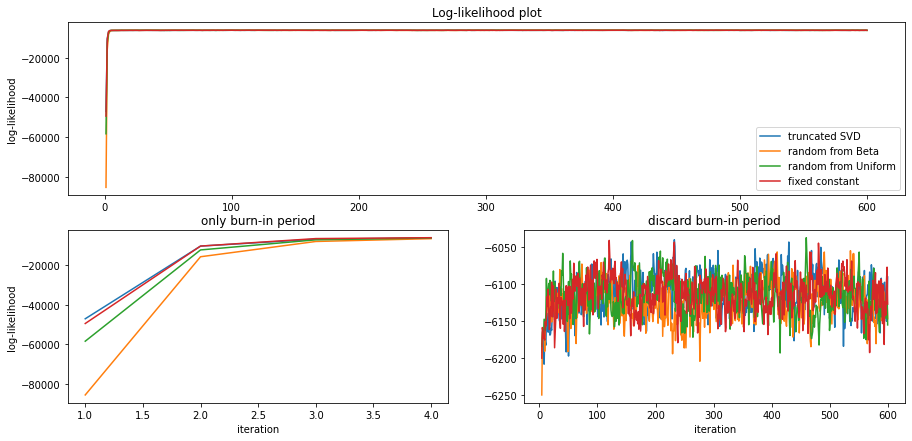

In [ ]:
plt.close()
fig = plt.figure(figsize=(15,7))

warm_up=0
ax1 = plt.subplot(211)
ax1.plot(np.linspace(1,num_iteration-warm_up,num_iteration-warm_up),log_likelihood_list1[warm_up:],label="truncated SVD")
ax1.plot(np.linspace(1,num_iteration-warm_up,num_iteration-warm_up),log_likelihood_list2[warm_up:],label="random from Beta")
ax1.plot(np.linspace(1,num_iteration-warm_up,num_iteration-warm_up),log_likelihood_list3[warm_up:],label="random from Uniform")
ax1.plot(np.linspace(1,num_iteration-warm_up,num_iteration-warm_up),log_likelihood_list4[warm_up:],label="fixed constant")

ax1.legend()
ax1.set_title("Log-likelihood plot")
ax1.set_ylabel("log-likelihood")

warm_up=4
ax2 = plt.subplot(223)
ax2.plot(np.linspace(1,warm_up,warm_up),log_likelihood_list1[:warm_up],label="truncated SVD")
ax2.plot(np.linspace(1,warm_up,warm_up),log_likelihood_list2[:warm_up],label="random from Beta")
ax2.plot(np.linspace(1,warm_up,warm_up),log_likelihood_list3[:warm_up],label="random from Uniform")
ax2.plot(np.linspace(1,warm_up,warm_up),log_likelihood_list4[:warm_up],label="fixed constant")
ax2.set_title("only burn-in period")
ax2.set_ylabel("log-likelihood")
ax2.set_xlabel("iteration")


ax3 = plt.subplot(224)
ax3.plot(np.linspace(warm_up, num_iteration, num_iteration-warm_up),log_likelihood_list1[warm_up:],label="truncated SVD")
ax3.plot(np.linspace(warm_up, num_iteration, num_iteration-warm_up),log_likelihood_list2[warm_up:],label="random from Beta")
ax3.plot(np.linspace(warm_up, num_iteration, num_iteration-warm_up),log_likelihood_list3[warm_up:],label="random from Uniform")
ax3.plot(np.linspace(warm_up, num_iteration, num_iteration-warm_up),log_likelihood_list4[warm_up:],label="fixed constant")

ax3.set_title("discard burn-in period")
ax3.set_xlabel("iteration")
plt.savefig("compare_inital_val.pdf", format="pdf", bbox_inches="tight")

### Different initialisation of $Q$ and $Q^\ast$

#### temporal observations

In [ ]:
# initialisation
x0, y0 = gib.init_xy(A, T, d)
Q0, Q0_star = gib.init_Q(A, T, M, N)

N0_mat, I0, I0_star = gib.sim_N_I(x0, y0, M, N, T, d, A_dense)

A0_sum_tj, A0_sum_ti = gib.sum_A(A, T, M, N)

# parameters of priors
a_x = 1
b_x = 2
c_x = 0.1

a_y = 1
b_y = 0.5
c_y = 0.3

alpha_x = 0.1
beta_x = 0.1
alpha_y = 0.3
beta_y = 1


# gibbs sampler
zeta_set = {}
zeta_star_set = {}
x_set = {}
y_set = {}
theta_set = {}
theta_star_set = {}
Q_set = {}
Q_star_set = {}
N_mat_set = {}
I_set = {}
I_star_set = {}

x_set[0] = x0
y_set[0] = y0
Q_set[0] = Q0
Q_star_set[0] = Q0_star

N_mat_set[0] = N0_mat
I_set[0] = I0
I_star_set[0] = I0_star

log_likelihood_list1 = []

num_iteration = 600


for num in range(1, num_iteration+1):
    zeta_set[num] = gib.sim_zeta( a_x, b_x, c_x, x_set[num-1], M, d)
    zeta_star_set[num] = gib.sim_zeta( a_y, b_y, c_y, y_set[num-1], N, d)

    x_set[num] = gib.sim_xy(y_set[num-1], I0_star, zeta_set[num], Q_set[num-1], Q_star_set[num-1], a_x, M, d)
    y_set[num] = gib.sim_xy(x_set[num], I0, zeta_star_set[num], Q_star_set[num-1], Q_set[num-1], a_y, N, d)

    theta_set[num] = gib.sim_theta(alpha_x, beta_x, Q_set[num-1], T, M)
    theta_star_set[num] = gib.sim_theta(alpha_y, beta_y, Q_star_set[num-1], T, N)

    Q_set[num] = gib.sim_Q(A0_sum_tj, x_set[num], y_set[num], Q_star_set[num-1], theta_set[num], M, T)
    Q_star_set[num] = gib.sim_Q(A0_sum_ti, y_set[num], x_set[num], Q_set[num], theta_star_set[num], N, T)
    

    N_mat_set[num],I0, I0_star = gib.sim_N_I(x_set[num], y_set[num], M, N, T, d, A_dense)
    log_likelihood_list1.append(gib.log_likelihood_PMF(A_dense, x_set[num], y_set[num], Q_set[num], Q_star_set[num], T, M, N))

#### random simulation:

In [ ]:
# initialisation random

x0, y0 = gib.init_xy(A, T, d)

Q0 = np.random.binomial(n=1, p=0.5, size=(M, T))
Q0_star = np.random.binomial(n=1, p=0.5, size=(N, T))


N0_mat, I0, I0_star = N_mat_set[0], I_set[0], I_star_set[0]


# gibbs sampler
zeta_set = {}
zeta_star_set = {}
x_set = {}
y_set = {}
theta_set = {}
theta_star_set = {}
Q_set = {}
Q_star_set = {}

x_set[0] = x0
y_set[0] = y0
Q_set[0] = Q0
Q_star_set[0] = Q0_star

log_likelihood_list5 = []


for num in range(1, num_iteration+1):
    zeta_set[num] = gib.sim_zeta( a_x, b_x, c_x, x_set[num-1], M, d)
    zeta_star_set[num] = gib.sim_zeta( a_y, b_y, c_y, y_set[num-1], N, d)

    x_set[num] = gib.sim_xy(y_set[num-1], I0_star, zeta_set[num], Q_set[num-1], Q_star_set[num-1], a_x, M, d)
    y_set[num] = gib.sim_xy(x_set[num], I0, zeta_star_set[num], Q_star_set[num-1], Q_set[num-1], a_y, N, d)

    theta_set[num] = gib.sim_theta(alpha_x, beta_x, Q_set[num-1], T, M)
    theta_star_set[num] = gib.sim_theta(alpha_y, beta_y, Q_star_set[num-1], T, N)

    Q_set[num] = gib.sim_Q(A0_sum_tj, x_set[num], y_set[num], Q_star_set[num-1], theta_set[num], M, T)
    Q_star_set[num] = gib.sim_Q(A0_sum_ti, y_set[num], x_set[num], Q_set[num], theta_star_set[num], N, T)
    

    N_mat_set[num],I0, I0_star = gib.sim_N_I(x_set[num], y_set[num], M, N, T, d, A_dense)
    log_likelihood_list5.append(gib.log_likelihood_PMF(A_dense, x_set[num], y_set[num], Q_set[num], Q_star_set[num], T, M, N))

#### Plot of MCs

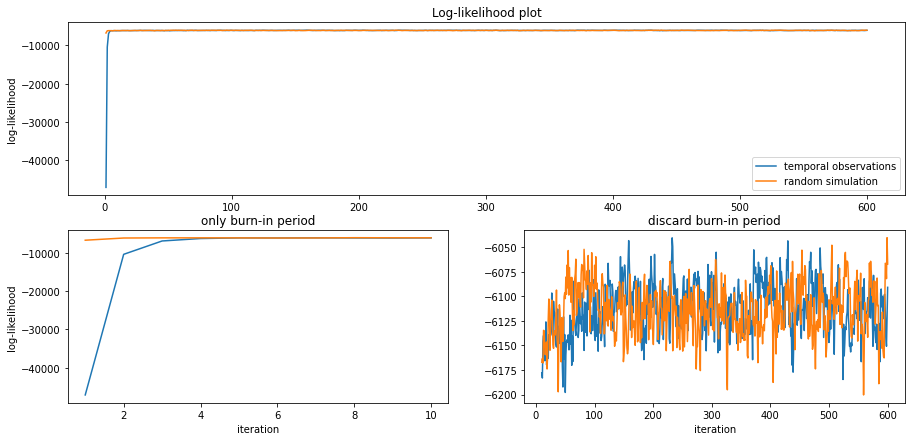

In [ ]:
plt.close()
fig = plt.figure(figsize=(15,7))

warm_up=0
ax1 = plt.subplot(211)
ax1.plot(np.linspace(1,num_iteration-warm_up,num_iteration-warm_up),log_likelihood_list1[warm_up:],label="temporal observations")
ax1.plot(np.linspace(1,num_iteration-warm_up,num_iteration-warm_up),log_likelihood_list5[warm_up:],label="random simulation")

ax1.legend()
ax1.set_title("Log-likelihood plot")
ax1.set_ylabel("log-likelihood")

warm_up=10
ax2 = plt.subplot(223)
ax2.plot(np.linspace(1,warm_up,warm_up),log_likelihood_list1[:warm_up],label="temporal observations")
ax2.plot(np.linspace(1,warm_up,warm_up),log_likelihood_list5[:warm_up],label="random simulationa")
ax2.set_title("only burn-in period")
ax2.set_ylabel("log-likelihood")
ax2.set_xlabel("iteration")


ax3 = plt.subplot(224)
ax3.plot(np.linspace(warm_up, num_iteration, num_iteration-warm_up),log_likelihood_list1[warm_up:],label="temporal observations")
ax3.plot(np.linspace(warm_up, num_iteration, num_iteration-warm_up),log_likelihood_list5[warm_up:],label="random simulation")
ax3.set_title("discard burn-in period")
ax3.set_xlabel("iteration")
plt.savefig("compare_inital_val2.pdf", format="pdf", bbox_inches="tight")

## Link prediction performance

### Relation between link prediction performance and network dimension

In [ ]:

# fixed cluster numbers
d = 2
# fixted time period
T = 5

# repeating number for same dimension
repeat_num = 10

# set of M and N
MN_list = [[20, 30],[50,80],[100,150]]

# record AUC
auc_mat_MN_dy = np.zeros((repeat_num, len(MN_list)))
auc_mat_MN_no_dy = np.zeros((repeat_num, len(MN_list)))

# parameters of priors
a_x = 1
b_x = 2
c_x = 0.1

a_y = 1
b_y = 0.5
c_y = 0.3

alpha_x = 0.1
beta_x = 0.1
alpha_y = 0.3
beta_y = 1

# number of iterations for Gibbs sampling
num_iteration = 300


for dim_idx in range(len(MN_list)):
    M,N = MN_list[dim_idx]

    for idx in range(repeat_num):
        # generate random networks
        A, A_count = random_sim_A(M, N, T, d, add_dynamics=True)
        A_dense = gib.convert_to_dense(A)

        # initialisation
        x0, y0 = gib.init_xy(A, T, d)
        Q0, Q0_star = gib.init_Q(A, T, M, N)

        N0_mat, I0, I0_star = gib.sim_N_I(x0, y0, M, N, T, d, A_dense)
        A0_sum_tj, A0_sum_ti = gib.sum_A(A, T, M, N)
        # gibbs sampler
        zeta_set = {}
        zeta_star_set = {}
        x_set = {}
        y_set = {}
        theta_set = {}
        theta_star_set = {}
        Q_set = {}
        Q_star_set = {}
        N_mat_set = {}
        I_set = {}
        I_star_set = {}

        x_set[0] = x0
        y_set[0] = y0
        Q_set[0] = Q0
        Q_star_set[0] = Q0_star

        N_mat_set[0] = N0_mat
        I_set[0] = I0
        I_star_set[0] = I0_star

        log_likelihood_list1 = []

        # with dynamics
        for num in range(1, num_iteration+1):
            zeta_set[num] = gib.sim_zeta( a_x, b_x, c_x, x_set[num-1], M, d)
            zeta_star_set[num] = gib.sim_zeta( a_y, b_y, c_y, y_set[num-1], N, d)

            x_set[num] = gib.sim_xy(y_set[num-1], I0_star, zeta_set[num], Q_set[num-1], Q_star_set[num-1], a_x, M, d)
            y_set[num] = gib.sim_xy(x_set[num], I0, zeta_star_set[num], Q_star_set[num-1], Q_set[num-1], a_y, N, d)

            theta_set[num] = gib.sim_theta(alpha_x, beta_x, Q_set[num-1], T, M)
            theta_star_set[num] = gib.sim_theta(alpha_y, beta_y, Q_star_set[num-1], T, N)

            Q_set[num] = gib.sim_Q(A0_sum_tj, x_set[num], y_set[num], Q_star_set[num-1], theta_set[num], M, T)
            Q_star_set[num] = gib.sim_Q(A0_sum_ti, y_set[num], x_set[num], Q_set[num], theta_star_set[num], N, T)
    

            N_mat_set[num],I0, I0_star = gib.sim_N_I(x_set[num], y_set[num], M, N, T, d, A_dense)
            #log_likelihood_list1.append(gib.log_likelihood_PMF(A_dense, x_set[num], y_set[num], Q_set[num], Q_star_set[num], T, M, N))
        
        # gibbs sampler without dynamics
        N0_mat, I1, I1_star = N_mat_set[0], I_set[0], I_star_set[0]
        Q1 = np.ones((M, T))
        Q1_star = np.ones((N, T))
        zeta_set2 = {}
        zeta_star_set2 = {}
        x_set2 = {}
        y_set2 = {}
        N_mat_set2 = {}

        x_set2[0] = x0
        y_set2[0] = y0
        N_mat_set2[0] = N0_mat

        for num in range(1, num_iteration+1):
            zeta_set2[num] = gib.sim_zeta( a_x, b_x, c_x, x_set2[num-1], M, d)
            zeta_star_set2[num] = gib.sim_zeta( a_y, b_y, c_y, y_set2[num-1], N, d)

            x_set2[num] = gib.sim_xy(y_set2[num-1], I1_star, zeta_set2[num], Q1, Q1_star, a_x, M, d)
            y_set2[num] = gib.sim_xy(x_set2[num], I1, zeta_star_set2[num], Q1_star, Q1, a_y, N, d)

            N_mat_set2[num],I1, I1_star = gib.sim_N_I(x_set2[num], y_set2[num], M, N, T, d, A_dense)

        # compute AUC 
        theta_set2 = {}
        theta_star_set2 = {}
        for l in range(num+1):
            theta_set2[l] = np.ones((M,))
            theta_star_set2[l] = np.ones((N,))
        
        link_prob1 = gib.possible_link_prob(x_set, y_set, theta_set, theta_star_set, M, N, 200)
        link_prob2 = gib.possible_link_prob(x_set2, y_set2, theta_set2, theta_star_set2, M, N, 200)

        positive_class, negative_class =gib.binary_class(A_dense[T], M, N)

        pred_prob1, actual_label1 = gib.pfm_pred(positive_class, negative_class, link_prob1)
        pred_prob2, actual_label2 = gib.pfm_pred(positive_class, negative_class, link_prob2)

        auc_mat_MN_dy[idx, dim_idx] = roc_auc_score(actual_label1, pred_prob1)
        auc_mat_MN_no_dy[idx, dim_idx] = roc_auc_score(actual_label2, pred_prob2)
    

    # plot AUC
    plt.plot(np.linspace(1, repeat_num, repeat_num), auc_mat_MN_dy[:, dim_idx], label="dynamics")
    plt.plot(np.linspace(1, repeat_num, repeat_num), auc_mat_MN_no_dy[:, dim_idx], label="no dynamicss")
    plt.legend()
    plt.xlabel("repeating iteration")
    plt.ylabel("AUC score")
    plt.title("AUC score for randomly simulated network in dimension %s * %s"%(M,N))
    plt.show()

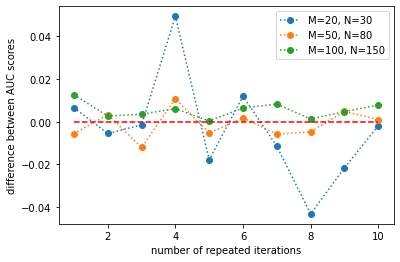

In [ ]:
# fixed cluster numbers
d = 2
# fixted time period
T = 5

# repeating number for same dimension
repeat_num = 10

# set of M and N
MN_list = [[20, 30],[50,80],[100,150]]

diff_auc = auc_mat_MN_dy - auc_mat_MN_no_dy

plt.plot(np.linspace(1, repeat_num, repeat_num), diff_auc[:,0], linestyle =":", marker="o",
label='M=%s, N=%s'%(MN_list[0][0],MN_list[0][1]))
plt.plot(np.linspace(1, repeat_num, repeat_num), diff_auc[:,1], linestyle =":", marker="o",
label='M=%s, N=%s'%(MN_list[1][0],MN_list[1][1]))
plt.plot(np.linspace(1, repeat_num, repeat_num), diff_auc[:,2], linestyle =":", marker="o",
label='M=%s, N=%s'%(MN_list[2][0],MN_list[2][1]))
plt.hlines(y=0, xmin=1, xmax=repeat_num, color="red",linestyle ="--" )
plt.legend()
plt.xlabel("number of repeated iterations")
plt.ylabel("difference between AUC scores")
plt.show()

### Relation between link prediction performance and network sparsity

In [ ]:
def random_sim_A_dy(M, N, T, d, theta, theta_star):
    A = {}
    A_count = {}

    B = np.random.beta(a=1,b=5, size=d*d).reshape((d, d))

    Z = np.array([random.randint(0,d-1) for m in range(M)])
    Z_star = np.array([random.randint(0,d-1) for n in range(N)])

    for t in range(T+1):
        A0 = Counter()
        Q = np.random.binomial(n=1, p=theta)
        Q_star = np.random.binomial(n=1, p=theta_star)

        for i in range(M):
            for j in range(N):
                link_ij = np.random.binomial(n=1, p=B[int(Z[i]), int(Z_star[j])])*Q[i]*Q_star[j]
                if link_ij==1:
                    A0[i,j] = 1

        A[t] = lanl.counter2A(A0,m=M,n=N)
        A_count[t] = A0
    
    return A, A_count

In [ ]:

# fixed cluster numbers
d = 2
# fixted time period
T = 5

# repeating number for same dimension
repeat_num = 10

# set of M and N
M = 100
N = 150

# theta setting
theta_list = [0.2, 0.5, 0.9, 0.7, 0.1]

# record AUC
auc_mat_theta_dy = np.load('auc_theta_dy.npy')
auc_mat_theta_dy = np.hstack((auc_mat_theta_dy,np.zeros((repeat_num,1))))
auc_mat_theta_no_dy = np.load('auc_theta_no_dy.npy')
auc_mat_theta_no_dy = np.hstack((auc_mat_theta_no_dy,np.zeros((repeat_num,1))))
#auc_mat_theta_dy = np.zeros((repeat_num, len(theta_list)))
#auc_mat_theta_no_dy = np.zeros((repeat_num, len(theta_list)))

# parameters of priors
a_x = 1
b_x = 2
c_x = 0.1

a_y = 1
b_y = 0.5
c_y = 0.3

alpha_x = 0.1
beta_x = 0.1
alpha_y = 0.3
beta_y = 1

# number of iterations for Gibbs sampling
num_iteration = 400


for dim_idx in [3]:
    theta = np.ones((M))*theta_list[dim_idx]
    theta_star = np.ones((N))*theta_list[dim_idx]

    for idx in range(2, repeat_num):

        # generate random networks
        A, A_count = random_sim_A_dy(M, N, T, d, theta, theta_star)
        A_dense = gib.convert_to_dense(A)

        # initialisation
        x0, y0 = gib.init_xy(A, T, d)
        Q0, Q0_star = gib.init_Q(A, T, M, N)

        N0_mat, I0, I0_star = gib.sim_N_I(x0, y0, M, N, T, d, A_dense)
        A0_sum_tj, A0_sum_ti = gib.sum_A(A, T, M, N)
        # gibbs sampler
        zeta_set = {}
        zeta_star_set = {}
        x_set = {}
        y_set = {}
        theta_set = {}
        theta_star_set = {}
        Q_set = {}
        Q_star_set = {}
        N_mat_set = {}
        I_set = {}
        I_star_set = {}

        x_set[0] = x0
        y_set[0] = y0
        Q_set[0] = Q0
        Q_star_set[0] = Q0_star

        N_mat_set[0] = N0_mat
        I_set[0] = I0
        I_star_set[0] = I0_star

        # with dynamics
        for num in range(1, num_iteration+1):
            zeta_set[num] = gib.sim_zeta( a_x, b_x, c_x, x_set[num-1], M, d)
            zeta_star_set[num] = gib.sim_zeta( a_y, b_y, c_y, y_set[num-1], N, d)

            x_set[num] = gib.sim_xy(y_set[num-1], I0_star, zeta_set[num], Q_set[num-1], Q_star_set[num-1], a_x, M, d)
            y_set[num] = gib.sim_xy(x_set[num], I0, zeta_star_set[num], Q_star_set[num-1], Q_set[num-1], a_y, N, d)

            theta_set[num] = gib.sim_theta(alpha_x, beta_x, Q_set[num-1], T, M)
            theta_star_set[num] = gib.sim_theta(alpha_y, beta_y, Q_star_set[num-1], T, N)

            Q_set[num] = gib.sim_Q(A0_sum_tj, x_set[num], y_set[num], Q_star_set[num-1], theta_set[num], M, T)
            Q_star_set[num] = gib.sim_Q(A0_sum_ti, y_set[num], x_set[num], Q_set[num], theta_star_set[num], N, T)
    

            N_mat_set[num],I0, I0_star = gib.sim_N_I(x_set[num], y_set[num], M, N, T, d, A_dense)
            #log_likelihood_list1.append(gib.log_likelihood_PMF(A_dense, x_set[num], y_set[num], Q_set[num], Q_star_set[num], T, M, N))
        
        # gibbs sampler without dynamics
        N0_mat, I1, I1_star = N_mat_set[0], I_set[0], I_star_set[0]
        Q1 = np.ones((M, T))
        Q1_star = np.ones((N, T))
        zeta_set2 = {}
        zeta_star_set2 = {}
        x_set2 = {}
        y_set2 = {}
        N_mat_set2 = {}

        x_set2[0] = x0
        y_set2[0] = y0
        N_mat_set2[0] = N0_mat

        for num in range(1, num_iteration+1):
            zeta_set2[num] = gib.sim_zeta( a_x, b_x, c_x, x_set2[num-1], M, d)
            zeta_star_set2[num] = gib.sim_zeta( a_y, b_y, c_y, y_set2[num-1], N, d)

            x_set2[num] = gib.sim_xy(y_set2[num-1], I1_star, zeta_set2[num], Q1, Q1_star, a_x, M, d)
            y_set2[num] = gib.sim_xy(x_set2[num], I1, zeta_star_set2[num], Q1_star, Q1, a_y, N, d)

            N_mat_set2[num],I1, I1_star = gib.sim_N_I(x_set2[num], y_set2[num], M, N, T, d, A_dense)

        # compute AUC 
        theta_set2 = {}
        theta_star_set2 = {}
        for l in range(num+1):
            theta_set2[l] = np.ones((M,))
            theta_star_set2[l] = np.ones((N,))
        
        link_prob1 = gib.possible_link_prob(x_set, y_set, theta_set, theta_star_set, M, N, 200)
        link_prob2 = gib.possible_link_prob(x_set2, y_set2, theta_set2, theta_star_set2, M, N, 200)

        positive_class, negative_class =gib.binary_class(A_dense[T], M, N)

        pred_prob1, actual_label1 = gib.pfm_pred(positive_class, negative_class, link_prob1)
        pred_prob2, actual_label2 = gib.pfm_pred(positive_class, negative_class, link_prob2)

        auc_mat_theta_dy[idx, dim_idx] = roc_auc_score(actual_label1, pred_prob1)
        auc_mat_theta_no_dy[idx, dim_idx] = roc_auc_score(actual_label2, pred_prob2)
        print(auc_mat_theta_dy[idx, dim_idx] - auc_mat_theta_no_dy[idx, dim_idx])
    

    # plot AUC
    plt.plot(np.linspace(1, repeat_num, repeat_num), auc_mat_theta_dy[:, dim_idx], label="dynamics")
    plt.plot(np.linspace(1, repeat_num, repeat_num), auc_mat_theta_no_dy[:, dim_idx], label="no dynamicss")
    plt.legend()
    plt.xlabel("repeating iteration")
    plt.ylabel("AUC score")
    plt.title("AUC score for randomly simulated network with \u03B8 = %s"%(theta_list[dim_idx]))
    plt.show()

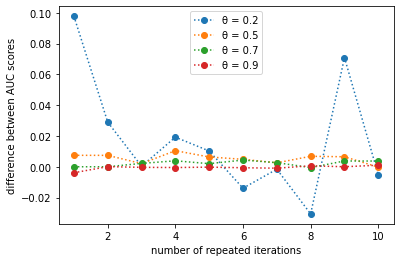

In [ ]:
diff_auc2 = auc_mat_theta_dy - auc_mat_theta_no_dy 
theta_list = [0.2, 0.5, 0.9, 0.7]
repeat_num=10
plt.plot(np.linspace(1, repeat_num, repeat_num), diff_auc2[:,0], linestyle =":", marker="o",
label='\u03B8 = %s'%(theta_list[0]))
plt.plot(np.linspace(1, repeat_num, repeat_num), diff_auc2[:,1], linestyle =":", marker="o",
label='\u03B8 = %s'%(theta_list[1]))
plt.plot(np.linspace(1, repeat_num, repeat_num), diff_auc2[:,3], linestyle =":", marker="o",
label='\u03B8 = %s'%(theta_list[3]))
plt.plot(np.linspace(1, repeat_num, repeat_num), diff_auc2[:,2], linestyle =":", marker="o",
label='\u03B8 = %s'%(theta_list[2]))
plt.legend(loc="upper center")
plt.xlabel("number of repeated iterations")
plt.ylabel("difference between AUC scores")
plt.show()

### Comparison in boxplot

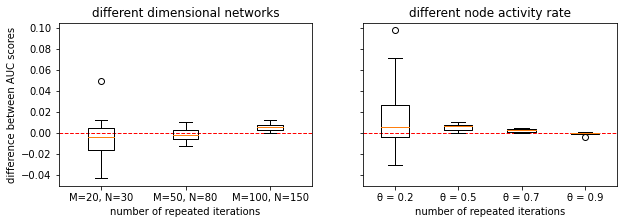

In [ ]:
# boxplot
fig, (ax1, ax2) = plt.subplots(1,2,sharey = True, figsize=(10,3))

data_1 = diff_auc[:,0]
data_2 = diff_auc[:,1]
data_3 = diff_auc[:,2]
data = [data_1, data_2, data_3]

data_11 = diff_auc2[:,0]
data_21 = diff_auc2[:,1]
data_31 = diff_auc2[:,3]
data_41 = diff_auc2[:,2]
data2 = [data_11, data_21, data_31, data_41]


 
# Creating axes instance
#ax = fig.add_axes([0, 0, 1, 1])

ax1.boxplot(data)
ax1.set_xticklabels(['M=20, N=30',"M=50, N=80","M=100, N=150"])
left = 0.5
right = 3.5
ax1.hlines(y=0, xmin=left, xmax=right, color="red",linestyle ="--",linewidth=1)
ax1.set_xlabel("number of repeated iterations")
ax1.set_ylabel("difference between AUC scores")
ax1.set_title("different dimensional networks")

ax2.boxplot(data2)
ax2.set_xticklabels(['\u03B8 = 0.2','\u03B8 = 0.5','\u03B8 = 0.7','\u03B8 = 0.9'])
left = 0.5
right = 4.5
ax2.hlines(y=0, xmin=left, xmax=right, color="red",linestyle ="--",linewidth=1)
ax2.set_xlabel("number of repeated iterations")
ax2.set_title("different node activity rate")
plt.savefig("compare_dim_theta.pdf", format="pdf", bbox_inches="tight")
plt.show()